# Methodologies for image processing of radar remote sensing data #

## Lecture 11: Topographic height changes
**Estimate ice loss over Switzerland from three DEMs:**1. SRTM (2000)
2.  ALOS (2006-2011)
3.  SwissAlti3D  2010 – 2011)

**Processing steps and tasks:**
1. Load DEMs
2. Explore the DEMs and hillshade
3. Coregister DEMs
4. Calculate DEM differences.


In [1]:
pip install rasterio   #we first need to install a package which is not installed on the Hub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# if you got an error: ModuleNotFoundError: No module named 'rasterio', run the cell above

## Section 1: LOAD DEMS 


In [3]:
# Load SRTM data
srtm_path = './DEMs/SRTMC-N46E008.tif'
with rasterio.open(srtm_path) as src:
    SRTM_ori = np.array(src.read(1), dtype=np.float32)

# Load ALOS data
alos_path = './DEMs/AWD30-N046E008_AVE_DSM.tif'
with rasterio.open(alos_path) as src:
    ALOS = np.array(src.read(1), dtype=np.float32)

# Load alti3D data
alti3d_path = './DEMs/Alti3D-N046E008.tif'
with rasterio.open(alti3d_path) as src:
    alti3D = np.array(src.read(1), dtype=np.float32)

# the SRTM is 1 pixel larger and seems to be "shifted" by 0.5,0.5 px vs. the other two DEMs.
# However, the SRTM is actually not shifted but the each pixel represents
# the height of the corner points of an area instead the height of the area itself.
# as the corner points are half a pixel from the center of the area we interpolate the SRTM
# such that each pixels represents the height at the center of the area instead of the height of the corner points.
# See "RasterPixelIsPoint" (SRTM) vs. "RasterPixelIsArea" (ALOS, Alti3D)
# for details look here: http://geotiff.maptools.org/spec/geotiff2.5.html#2.5.2


## Section 2: Mark invalid values and interpolate SRTM


In [4]:
# Replace NaN values in SRTM and alti3D with np.nan
SRTM_nan = -32767
alti3D_nan = 0
SRTM_ori[SRTM_ori == SRTM_nan] = np.nan
alti3D[alti3D == alti3D_nan] = np.nan

# interpolate the SRTM DEM
from scipy.interpolate import RegularGridInterpolator

input_array = SRTM_ori

# Define the x and y coordinates for the input array
x = np.arange(input_array.shape[1])
y = np.arange(input_array.shape[0])
# Create RegularGridInterpolator for bilinear interpolation
interp = RegularGridInterpolator((y, x), input_array, method='linear', bounds_error=False, fill_value=np.nan)
# Define the coordinates for the output 3x3 array with resampling at x+0.5, y+0.5 pixels
x_output = np.arange(0.5, input_array.shape[1] - 0.5, 1)
y_output = np.arange(0.5, input_array.shape[0] - 0.5, 1)
# Create a meshgrid for output coordinates
x_grid, y_grid = np.meshgrid(x_output, y_output)
# Perform bilinear interpolation to obtain the 3x3 output array
output_array = interp((y_grid.flatten(), x_grid.flatten()))
output_array = output_array.reshape((len(y_output), len(x_output)))
SRTM=output_array
#print(SRTM)


## Section 3: visualizing DEMs. consider NaN or no-data values and remove or clip them before visualization.


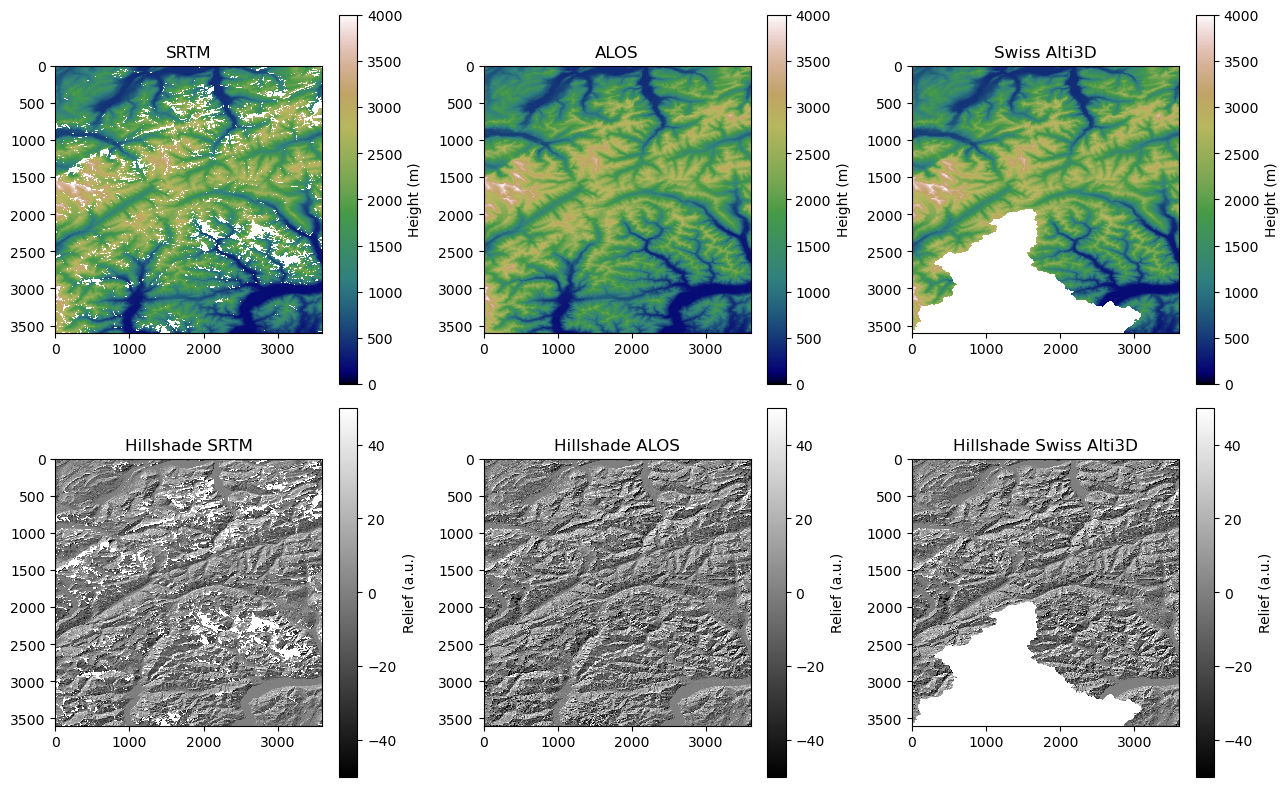

In [5]:
#This code will create a figure with six subplots, displaying the DEMs and their hillshade images (gradients) using the specified colormaps and colorbars.

fig = plt.figure(figsize=(13, 8))  # Create a figure with specified size

# Subplot 1: SRTM
ax1 = plt.subplot(231)
im1 = ax1.imshow(SRTM, interpolation='none', vmin=0, vmax=4000, cmap='gist_earth')
ax1.set_title('SRTM')
c1 = plt.colorbar(im1, ax=ax1)
c1.set_label('Height (m)')

# Subplot 2: ALOS
ax2 = plt.subplot(232)
im2 = ax2.imshow(ALOS, interpolation='none', vmin=0, vmax=4000, cmap='gist_earth')
ax2.set_title('ALOS')
c2 = plt.colorbar(im2, ax=ax2)
c2.set_label('Height (m)')

# Subplot 3: Swiss Alti3D
ax3 = plt.subplot(233)
im3 = ax3.imshow(alti3D, interpolation='none', vmin=0, vmax=4000, cmap='gist_earth')
ax3.set_title('Swiss Alti3D')
c3 = plt.colorbar(im3, ax=ax3)
c3.set_label('Height (m)')

# Calculate hillshade images or image gradients
dem1_gradient = SRTM - np.roll(SRTM, shift=(1, 1), axis=(0, 1))
dem2_gradient = ALOS - np.roll(ALOS, shift=(1, 1), axis=(0, 1))
dem3_gradient = alti3D - np.roll(alti3D, shift=(1, 1), axis=(0, 1))

# Subplot 4: Hillshade SRTM
ax4 = plt.subplot(234)
im4 = ax4.imshow(dem1_gradient, interpolation='none', vmin=-50, vmax=50, cmap='gray')
ax4.set_title('Hillshade SRTM')
c4 = plt.colorbar(im4, ax=ax4)
c4.set_label('Relief (a.u.)')

# Subplot 5: Hillshade ALOS
ax5 = plt.subplot(235)
im5 = ax5.imshow(dem2_gradient, interpolation='none', vmin=-50, vmax=50, cmap='gray')
ax5.set_title('Hillshade ALOS')
c5 = plt.colorbar(im5, ax=ax5)
c5.set_label('Relief (a.u.)')

# Subplot 6: Hillshade Swiss Alti3D
ax6 = plt.subplot(236)
im6 = ax6.imshow(dem3_gradient, interpolation='none', vmin=-50, vmax=50, cmap='gray')
ax6.set_title('Hillshade Swiss Alti3D')
c6 = plt.colorbar(im6, ax=ax6)
c6.set_label('Relief (a.u.)')

plt.tight_layout()
plt.show()

## For the sections below: 
1. run section 4-7 using x_shift=0 and y_shift=0, 

2. please estimate x_shift and y_shift by running section 8, if the output is Offset(subtract for correction) = (0.2,0.5), 

3. update x_shift = 0.2, y_shift=0.5 and run section 1-8 again; 

4. You can compare the result before shift and after shift.



## Section 4: select here the first (earlier) and second (later) DEM for DEM differencing: Difference = DEM2 - DEM1.


In [6]:
# Section 4: select here the first (earlier) and second (later) DEM for DEM differencing: Difference = DEM2 - DEM1.
# SRTM (2000), ALOS(2006-2011), Alti3D (release: 2013, update 2010/2011)
# three cases: (the first is always the newer one -> positive values = height increase, negative values = height loss)
# diff_case 1: Alti3D - ALOS
# diff_case 2: Alti3D - SRTM
# diff_case 3: ALOS   - SRTM

# Set the diff_case (choose 1, 2, or 3)
diff_case = 3

if diff_case == 1:
    dem1 = ALOS
    dem2 = alti3D
    dem1_name = 'ALOS'
    dem2_name = 'Alti3D'
    x_shift = 0  # Pixel shift to match DEMs horizontally.
    y_shift = 0

# Perform boxcar filtering to adapt the effective resolution
from scipy.ndimage import uniform_filter
if diff_case in [2, 3]:
    filter_size = 3  # Size of the boxcar filter
    boxcar_filter = np.ones((filter_size, filter_size)) / filter_size ** 2

if diff_case == 2:
    dem1 = SRTM
    dem2 = uniform_filter(alti3D, size=filter_size, mode='constant', cval=0)
    dem1_name = 'SRTM'
    dem2_name = 'Alti3D'
    x_shift = 0
    y_shift = 0

if diff_case == 3:
    dem1 = SRTM
    dem2 = uniform_filter(ALOS, size=filter_size, mode='constant', cval=0)
    dem1_name = 'SRTM'
    dem2_name = 'ALOS'
    x_shift = 0
    y_shift = 0




## Section 5: here the first DEM is shifted for precise subpixel horizontal misalignment.


In [7]:
#---Section 5: here the first DEM is shifted for precise subpixel horizontal misalignment.
# it is actually possible that you find a small shift (few tenth of a pixel) such that that two DEMs are better aligned.
# create gridded 2D array indices for bilinear interpolation.
# bilinear interpolation which resamples the DEM at x+shift, y+shift pixels.

# interpolate the SRTM DEM
# Create grid coordinates
x = np.arange(1, dem1.shape[1] + 1)
y = np.arange(1, dem1.shape[0] + 1)

# Create the interpolation function
interp_func = RegularGridInterpolator((y, x), dem1, method='linear', bounds_error=False, fill_value=None)

# Create the new grid coordinates
Xq, Yq = np.meshgrid(x + x_shift, y + y_shift)

# Perform the interpolation
dem1 = interp_func((Yq, Xq))

## Section 6: vertically adjust DEMs

In [8]:
#---section 6: vertically adjust DEMs----
# Calculate the median difference while omitting NaN values
median_difference = np.nanmedian(dem2 - dem1)

# Vertically adjust dem2 by subtracting the median difference
dem2 = dem2 - median_difference

print(f'Median difference {dem2_name} - {dem1_name} for vertical adjustment: {median_difference:.1f} m.')
print(f'Mean difference {dem2_name} - {dem1_name} after adjustment: {np.nanmean(dem2 - dem1):.1f} m.')

Median difference ALOS - SRTM for vertical adjustment: 2.8 m.
Mean difference ALOS - SRTM after adjustment: -0.8 m.


## Section 7: visualization  - apply smoothing window to DEM difference to smooth out noise.


RMSE between DEMs: 18.67 m.


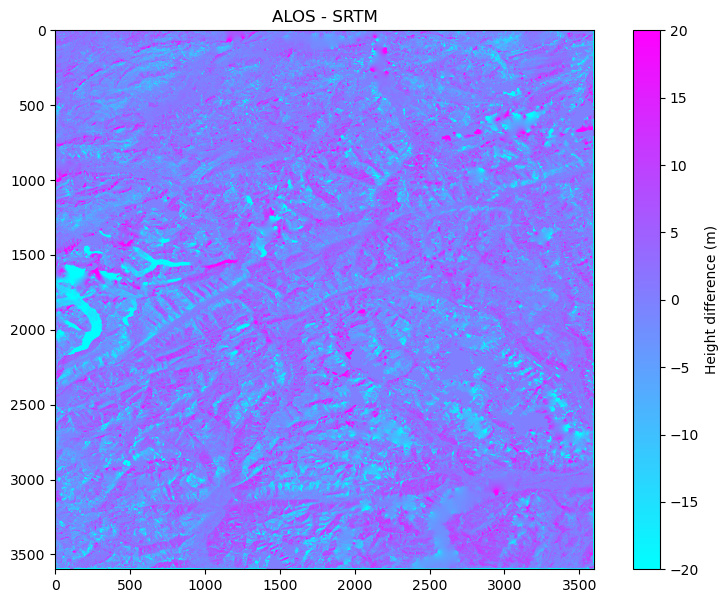

In [9]:
#---section 7: visualization  - apply smoothing window to DEM difference to smooth out noise.
from scipy.ndimage import uniform_filter

# Calculate the DEM difference and set NaN values to 0
DEM_difference = dem2 - dem1
DEM_difference[np.isnan(DEM_difference)] = 0

# Calculate RMSE
rmse = np.sqrt(np.sum(DEM_difference**2) / np.size(DEM_difference))
print(f'RMSE between DEMs: {rmse:.2f} m.')

# Define the boxcar size for smoothing
boxcar_size = 5

# Smooth the DEM difference using a uniform filter
smoothed_difference = uniform_filter(DEM_difference, size=boxcar_size)

# Create a figure for visualization
fig = plt.figure(figsize=(10, 7))

# Create a subplot for the smoothed DEM difference
ax = plt.subplot(1, 1, 1)
im = ax.imshow(smoothed_difference, vmin=-20, vmax=20, cmap='cool')
ax.set_title(f'{dem2_name} - {dem1_name}')
c1 = plt.colorbar(im)
c1.set_label('Height difference (m)')

plt.show()


## Now, we need to estimate the offset.

Below, you will find a cell dedicated to estimating the offset in the x and y directions. To enhance your understanding of the lines, you can compare them with the theories presented in the slides. When you run the cell, it will print the estimated offset. You should manually input this offset in Section 4: x_shift and y_shift, and then rerun all the subsequent cells.

**Task:** 
Write the cell below into a function that automatically inputs the estimated offset into Section 4.


Offset (subtract for correction) = (0.23748145692690567, 0.09009555337517423)


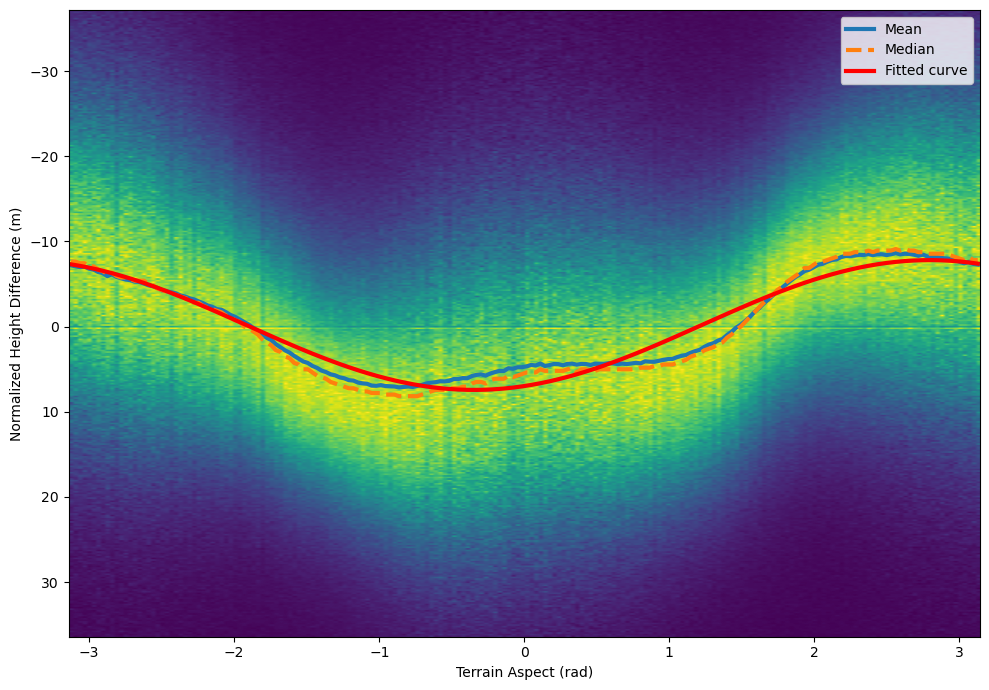

In [10]:
from scipy.ndimage import convolve

# Define parameters
dem_pixelspacing = 30  # meters
dzdykernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / (8.0 * dem_pixelspacing)
dzdxkernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / (8.0 * dem_pixelspacing)
min_slope = 10  # degree

# Calculate gradient using convolution
dzdx = convolve((dem1 + dem2) / 2, np.rot90(dzdxkernel,2), mode='constant', cval=np.nan)
dzdy = convolve((dem1 + dem2) / 2, np.rot90(dzdykernel,2), mode='constant', cval=np.nan)

# Set edge-pixels to NaN
dzdx[:2, :] = np.nan
dzdx[-2:, :] = np.nan
dzdx[:, :2] = np.nan
dzdx[:, -2:] = np.nan
dzdy[:2, :] = np.nan
dzdy[-2:, :] = np.nan
dzdy[:, :2] = np.nan
dzdy[:, -2:] = np.nan

# Calculate local gradient and slope aspect
grad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))  # 0 ... pi/2
aspect = np.arctan2(dzdy, dzdx)  # -pi..pi

# Remove areas which are too flat
grad[grad < min_slope / 180 * np.pi] = np.nan

# Calculate slope-normalized height differences
normdiff = (dem2 - dem1) / np.tan(grad)

# Estimate data range of normdiff
normdiff_std = np.nanstd(normdiff)
normdiff_mean = np.nanmean(normdiff)

# Calculate histogram bins with appropriate data range
hdiff_axis = np.arange(-2 * normdiff_std, 2 * normdiff_std + normdiff_mean, normdiff_std / 100)
aspect_bins = np.arange(-np.pi, np.pi + np.pi / 100, np.pi / 100)
aspect_axis = 0.5 * (aspect_bins[:-1] + aspect_bins[1:])

# Generate a 2D histogram to quickly evaluate how the height error varies with slope aspect
h2, _, _ = np.histogram2d(aspect.ravel(), normdiff.ravel(), bins=(aspect_bins, hdiff_axis))
h2 /= np.max(h2, axis=1)[:, np.newaxis]  # Normalize columns in the histogram


hdiff_over_aspect_mean = np.zeros(len(aspect_axis))
hdiff_over_aspect_median = np.zeros(len(aspect_axis))

for j in range(len(aspect_axis)):
    # Calculate mean height difference per aspect
    hdiff_over_aspect_mean[j] = np.sum(h2[j, :] * hdiff_axis[:-1]) / np.sum(h2[j, :])

    # Calculate median height difference per aspect
    cumulative_sum = np.cumsum(h2[j, :]) / np.sum(h2[j, :])
    median_index = np.argmax(cumulative_sum >= 0.5)
    hdiff_over_aspect_median[j] = hdiff_axis[median_index]

    # Normalize the histogram row to calculate the PDF
    h2[j, :] /= np.max(h2[j, :])

hdiff_over_aspect = hdiff_over_aspect_mean
# Fit a sine function to the mean slope-normalized height difference
hdiff_aspect_fft = np.fft.fft(hdiff_over_aspect)
hdiff_aspect_fft[2:-1] = 0  # Apply frequency filter to keep only the fundamental frequency
hdiff_aspect_fit = np.fft.ifft(hdiff_aspect_fft).real

# Calculate the offset
n = len(hdiff_aspect_fft)
x_shift = -2 * hdiff_aspect_fft[1].real / n / dem_pixelspacing
y_shift = -2 * hdiff_aspect_fft[1].imag / n / dem_pixelspacing

print(f'Offset (subtract for correction) = ({x_shift}, {y_shift})')


plt.figure(figsize=(10, 7))
# Plot 2D Histogram
#plt.imshow(h2.T, cmap='viridis')
plt.imshow(h2.T, extent=[-np.pi, np.pi, 2 * normdiff_std + normdiff_mean,-2 * normdiff_std], cmap='viridis', aspect='auto')
plt.xlabel('Terrain Aspect (rad)')
plt.ylabel('Normalized Height Difference (m)')
# Plot the Fitted Curve on top
plt.plot(aspect_axis, hdiff_over_aspect_mean, label='Mean', linewidth=3)
plt.plot(aspect_axis, hdiff_over_aspect_median, label='Median', linestyle='--',linewidth=3)
plt.plot(aspect_axis, hdiff_aspect_fit,label='Fitted curve', linewidth=3,  color='red')

plt.xlabel('Terrain Aspect (rad)')
plt.ylabel('Normalized Height Difference (m)')
plt.legend()

plt.tight_layout()
plt.show()